In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("/home/postdoc/dsen/Desktop/Biometrika-code/mbsampler.jl")
include("/home/postdoc/dsen/Desktop/Biometrika-code/zz_structures.jl")

compute_ESS (generic function with 1 method)

In [2]:
stratified = false
cov_dists = ["Laplace", "Gaussian", "uniform"]
n_reps = 50

50

### Scaling with covariate sparsity:

In [27]:
d = 5
subfolder = "scaling_pX"
pX_list = logspace(-2,0,8)
bts_pX = zeros(length(pX_list), n_reps, 4, length(cov_dists))
@showprogress for rep in 1:n_reps
    for (i,pX) in enumerate(pX_list) 
        for CV in [true,false] 
            for weighted in [true,false] 
                for (j,cov_dist) in enumerate(cov_dists)
                    filename  = "/xtmp/PDMP_data_revision/"*subfolder*"/cov_dist:"*cov_dist*"-pX:"*
                                string(pX)*"-rep:"*string(rep)*"-stratified:"*string(stratified)*
                                "-CV:"*string(CV)*"-weighted:"*string(weighted)*"-d:"*string(d)*".jld"
                                skel, bt = load(filename, "xt_skeleton", "bt_skeleton")
                    bts_pX[i,rep,1+CV+2*weighted,j] = bt[end]
                    skel, bt = nothing, nothing
                    gc()
                end
            end
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:06:50


#### Larger value of $d$:

### Scaling with increasing data size:

In [28]:
d = 5
subfolder = "scaling_Nobs"
Nobs_list = Int.(floor.(logspace(1,4.5,8)))
bts_Nobs = zeros(length(Nobs_list), n_reps, 4, length(cov_dists))
@showprogress for rep in 1:n_reps
    for (i,Nobs) in enumerate(Nobs_list) 
        for CV in [true,false] 
            for weighted in [true,false] 
                for (j,cov_dist) in enumerate(cov_dists)
                    filename = "/xtmp/PDMP_data_revision/"*subfolder*"/cov_dist:"*cov_dist*"-Nobs:"*
                                string(Nobs)*"-rep:"*string(rep)*"-stratified:"*string(stratified)*
                                "-CV:"*string(CV)*"-weighted:"*string(weighted)*"-d:"*string(d)*".jld"
                    skel, bt = load(filename, "xt_skeleton", "bt_skeleton")
                    bts_Nobs[i,rep,1+CV+2*weighted,j] = bt[end]
                    skel, bt = nothing, nothing
                    gc()
                end
            end
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:06:54


### Plots (no control variates):

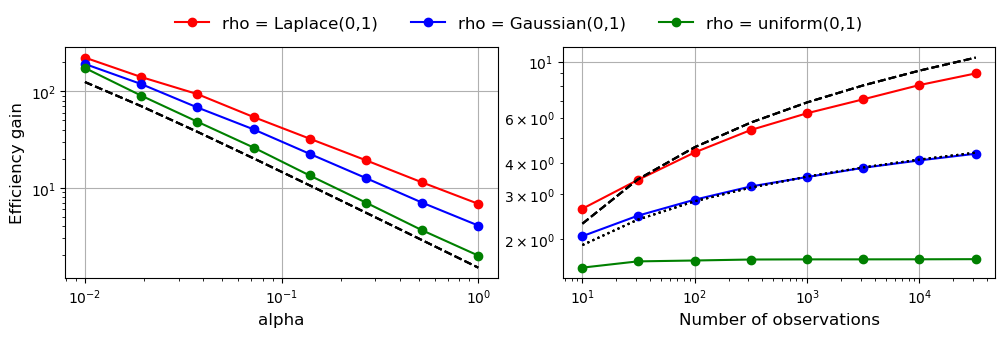

In [29]:
fig = figure("pyplot_subplot_mixed", figsize=(12,3))
subplot(121)
to_plot = zeros(size(bts_pX,1),2,3)
for i in 1:size(to_plot,1) 
    for j in 1:3
        a, b = bts_pX[i,:,3,j]./bts_pX[i,:,1,j], bts_pX[i,:,4,j]./bts_pX[i,:,2,j]
        to_plot[i,1,j] = mean(a[a.<Inf])
        to_plot[i,2,j] = mean(b[b.<Inf])
    end
end

colours = ["red", "blue", "green"]
pX_list = logspace(-2,0,8)
Nobs = 500
for (j,cov_dist) in enumerate(cov_dists)
    plot(pX_list, to_plot[:,1,j], "o-", color=colours[j], label="rho = "*cov_dist*"(0,1)")
    plot(pX_list, 1.5*pX_list*Nobs./(1+pX_list*Nobs)./pX_list, "--", color="black")
    xlabel("alpha", fontsize=12)
    ylabel("Efficiency gain", fontsize=12)
    grid(true)
    xscale("log")
    yscale("log")
end
legend(frameon=false, ncol=4,bbox_to_anchor=(0.22, 1.2), loc=2, fontsize=12)

subplot(122)
Nobs_list = Int.(floor.(logspace(1,4.5,8)))
p1 = log.(Nobs_list)
p2 = sqrt.(log.(Nobs_list.^2./(2*pi*log.(Nobs_list.^2/(2*pi))))).*(1+1./log.(Nobs_list))

for (j,cov_dist) in enumerate(cov_dists)
    plot(Nobs_list, mean(bts_Nobs[:,:,3,j]./bts_Nobs[:,:,1,j],2), "o-", color=colours[j])
    plot(Nobs_list, p1, "k--")
    plot(Nobs_list, p2, "k:")
    xlabel("Number of observations", fontsize=12)
    grid(true)
    xscale("log")
    yscale("log")
end
subplots_adjust(wspace=0.15)
# savefig("plots/scaling_bounds_noCV.pdf", format="pdf", dpi=10000, bbox_inches="tight");

### Plots (with control variates):

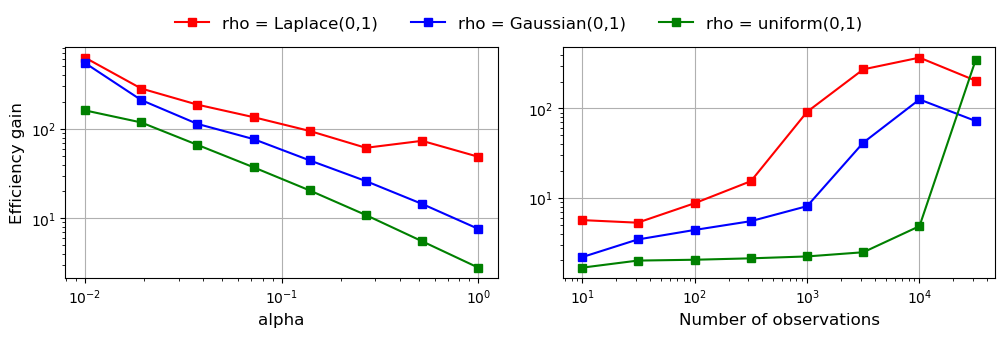

In [51]:
fig = figure("pyplot_subplot_mixed", figsize=(12,3))
subplot(121)
to_plot = zeros(size(bts_pX,1),2,3)
for i in 1:size(to_plot,1) 
    for j in 1:3
        a, b = bts_pX[i,:,3,j,1]./bts_pX[i,:,1,j,1], bts_pX[i,:,4,j,1]./bts_pX[i,:,2,j,1]
        to_plot[i,1,j] = mean(a[a.<Inf])
        to_plot[i,2,j] = mean(b[b.<Inf])
    end
end
colours = ["red", "blue", "green"]
pX_list = logspace(-2,0,8)
Nobs_list = repeat([500], length(pX_list))
for (j,cov_dist) in enumerate(cov_dists)
    plot(pX_list, to_plot[:,2,j], "s-", color=colours[j], label="rho = "cov_dist*"(0,1)")
    xlabel("alpha", fontsize=12)
    ylabel("Efficiency gain", fontsize=12)
    grid(true)
    xscale("log")
    yscale("log")
end
legend(frameon=false, ncol=4,bbox_to_anchor=(0.22, 1.2), loc=2, fontsize=12)
subplot(122)
k = 1
colours = ["red", "blue", "green"]
Nobs_list = Int.(floor.(logspace(1,4.5,8)))
p1 = log.(Nobs_list)
p2 = sqrt.(log.(Nobs_list.^2./(2*pi*log.(Nobs_list.^2/(2*pi))))).*(1+1./log.(Nobs_list))

to_plot = zeros(size(bts_Nobs,1),2,3)
for i in 1:size(to_plot,1) 
    for j in 1:3
        a, b = bts_Nobs[i,:,3,j,1]./bts_Nobs[i,:,1,j,1], bts_Nobs[i,:,4,j,1]./bts_Nobs[i,:,2,j,1]
        to_plot[i,1,j] = mean(a[a.<Inf])
        to_plot[i,2,j] = mean(b[b.<Inf])
    end
end

for (j,cov_dist) in enumerate(cov_dists)    
#     plot(Nobs_list, mean(bts_Nobs[:,:,4,j]./bts_Nobs[:,:,2,j],2), "s-", 
#          color=colours[j], label="cov_dist:"cov_dist)
    plot(Nobs_list, to_plot[:,2,j], "s-", color=colours[j])
    xlabel("Number of observations", fontsize=12)
    grid(true)
    xscale("log")
    yscale("log")
end
subplots_adjust(wspace=0.15)
# savefig("plots/scaling_bounds_CV.pdf", format="pdf", dpi=10000, bbox_inches="tight");

### Other plots:

In [8]:
ZZ_weigh_noCV_xi_skel = 
load("/xtmp/PDMP_data/no_preconditioning/ZZ_weighted_noCV_skeleton.jld", 
     "skeleton")
ZZ_weigh_noCV_bt_skel = 
load("/xtmp/PDMP_data/no_preconditioning/ZZ_weighted_noCV_bouncetimes.jld", 
     "bouncetimes")

discard = 0
n_samples = 10^3
xi_samples_weigh_noCV = extract_samples(ZZ_weigh_noCV_xi_skel[:,discard+1:end], 
                             ZZ_weigh_noCV_bt_skel[:,discard+1:end], 
                             (ZZ_weigh_noCV_bt_skel[end]-ZZ_weigh_noCV_bt_skel[discard+1])/n_samples)

d_out = size(xi_samples_weigh_noCV,1)
maxlag = 200
acfs_weigh_noCV_no_precond = zeros(d_out, maxlag+1)
for dim in 1:d_out 
    acfs_weigh_noCV_no_precond[dim,:] = acf(xi_samples_weigh_noCV[dim,:], maxlag)
end

acfs_toplot_weigh_noCV_no_precond = []
xt = []
for i in 1:Int(maxlag/10) 
    push!(acfs_toplot_weigh_noCV_no_precond, acfs_weigh_noCV_no_precond[:,i*10])
    if i%5 == 0 
        push!(xt, 10*i)
    else 
        push!(xt, "")
    end
end

In [9]:
ZZ_weigh_noCV_xi_skel = 
load("/xtmp/PDMP_data/preconditioning_byvar/ZZ_weighted_noCV_skeleton.jld", 
     "skeleton")
ZZ_weigh_noCV_bt_skel = 
load("/xtmp/PDMP_data/preconditioning_byvar/ZZ_weighted_noCV_bouncetimes.jld", 
     "bouncetimes")

discard = 0
n_samples = 10^3
xi_samples_weigh_noCV = extract_samples(ZZ_weigh_noCV_xi_skel[:,discard+1:end], 
                             ZZ_weigh_noCV_bt_skel[:,discard+1:end], 
                             (ZZ_weigh_noCV_bt_skel[end]-ZZ_weigh_noCV_bt_skel[discard+1])/n_samples)

d_out = size(xi_samples_weigh_noCV,1)
maxlag = 200
acfs_weigh_noCV_precond = zeros(d_out, maxlag+1)
for dim in 1:d_out 
    acfs_weigh_noCV_precond[dim,:] = acf(xi_samples_weigh_noCV[dim,:], maxlag)
end

acfs_toplot_weigh_noCV_precond = []
xt = []
for i in 1:Int(maxlag/10) 
    push!(acfs_toplot_weigh_noCV_precond, acfs_weigh_noCV_precond[:,i*10])
    if i%5 == 0 
        push!(xt, 10*i)
    else 
        push!(xt, "")
    end
end

In [10]:
d, Nobs = 10, 5000
pX = 1e-1
nY_list = 5.^(0:5);

In [11]:
cov_dist = "Laplace"
n_samples = 10^5
maxlags = [600, 600, 400, 300, 2000, 4000]
iact_ratio = zeros(length(maxlags))
for (j,nY) in enumerate(nY_list) 
    filename = "/xtmp/PDMP_data_revision/CV_tests/CV-cov_dist:"*cov_dist*"-pX:"*
                string(pX)*"-nY:"*string(nY)*"-Nobs:"*string(Nobs)*"-d:"*string(d)*".jld"
    skel_CV, bt_CV = load(filename, "xt_skeleton", "bt_skeleton")
    xi_samples_CV = extract_samples(skel_CV, bt_CV, bt_CV[end]/n_samples, "linear")

    filename = "/xtmp/PDMP_data_revision/CV_tests/noCV-cov_dist:"*cov_dist*"-pX:"*
                string(pX)*"-nY:"*string(nY)*"-Nobs:"*string(Nobs)*"-d:"*string(d)*".jld"
    skel_noCV, bt_noCV = load(filename, "xt_skeleton", "bt_skeleton")
    xi_samples_noCV = extract_samples(skel_noCV, bt_noCV, bt_noCV[end]/n_samples, "linear")
    
    d = size(xi_samples_CV,1)
    @assert size(xi_samples_CV,1) == size(xi_samples_noCV,1)
    iact_ratio[j] = maximum([sum(acf(xi_samples_noCV[i,1000:end-2], maxlags[j]))/
                            sum(acf(xi_samples_CV[i,1000:end-2], maxlags[j])) 
                             for i in 1:d])
    skel_CV, bt_CV, xi_samples_CV, skel_noCV, bt_noCV, xi_samples_noCV = [], [], [], [], [], []
    gc()
    print(j, " ")
end

1 2 3 4 5 6 

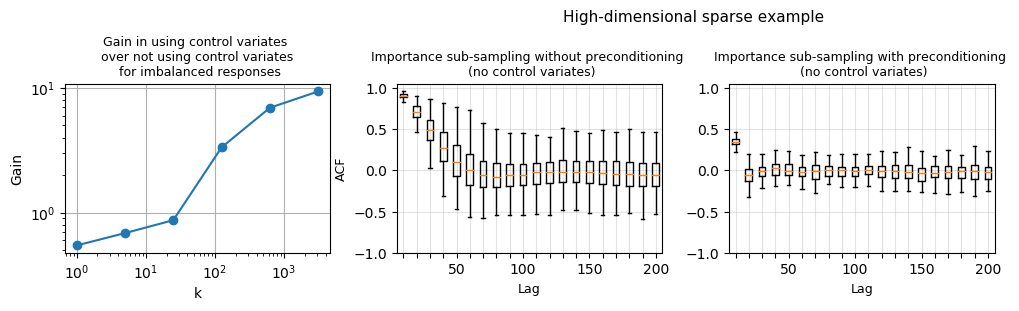

In [12]:
using PyPlot
fig = figure("pyplot_subplot_mixed", figsize=(12,2.2))

a, b = -1, 1.05

subplot(131)
nY_list = 5.^(0:5)
iact_ratio = [0.547211, 0.686738, 0.871628, 3.34095, 6.93208, 9.37147];
plot(nY_list, iact_ratio, "o-")
xscale("log");
grid(true)
yscale("log")
xlabel("k")
ylabel("Gain")
title("Gain in using control variates \n over not using control variates \n for imbalanced responses", 
    fontsize=9)
subplots_adjust(wspace=0.25)

subplot(132)
boxplot(acfs_toplot_weigh_noCV_no_precond, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=9)
xticks(1:20, xt)
ylim([a,b])
ylabel("ACF", fontsize=9)
title("Importance sub-sampling without preconditioning \n (no control variates)", fontsize=9)

subplot(133)
boxplot(acfs_toplot_weigh_noCV_precond, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=9)
xticks(1:20, xt)
ylim([a,b])
# ylabel("ACF", fontsize=9)
# yticks(alpha=0)
title("Importance sub-sampling with preconditioning \n (no control variates)", fontsize=9)
text(-12, 1.8, "High-dimensional sparse example", fontsize=11);

# savefig("plots/highdim+scaling.pdf", format="pdf", dpi=10000, bbox_inches="tight")